# Hebrew Words Analysis

**Submitter:** Eyal Shahimov

## The Goal - Verbs

As the common phrase goes, _"עברית שפה קשה"_.
This is probably true. Hebrew is a complex language with a rich vocabulary and intricate grammar rules.
We will explore some of these challenges by analyzing verbs in Hebrew.
Our goal is to successfully analyze verbs to their roots, pronouns, tenses, etc.

## The Data

Luckily for us, the Hebrew Language Academy provides a free online dictionary.
This dictionary also includes "לוח נטיות פועל" - a conjugation table for verbs.

![image](./resources/conjugation_table.png)

This table includes all the information we need to analyze verbs.
It contains the verb's root ("שורש"), tense ("זמן"), pronoun ("גוף") and stem ("בניין").

We will use this data to build a verb analyzer, because the Hebrew Language Academy is the official authority on the Hebrew language.
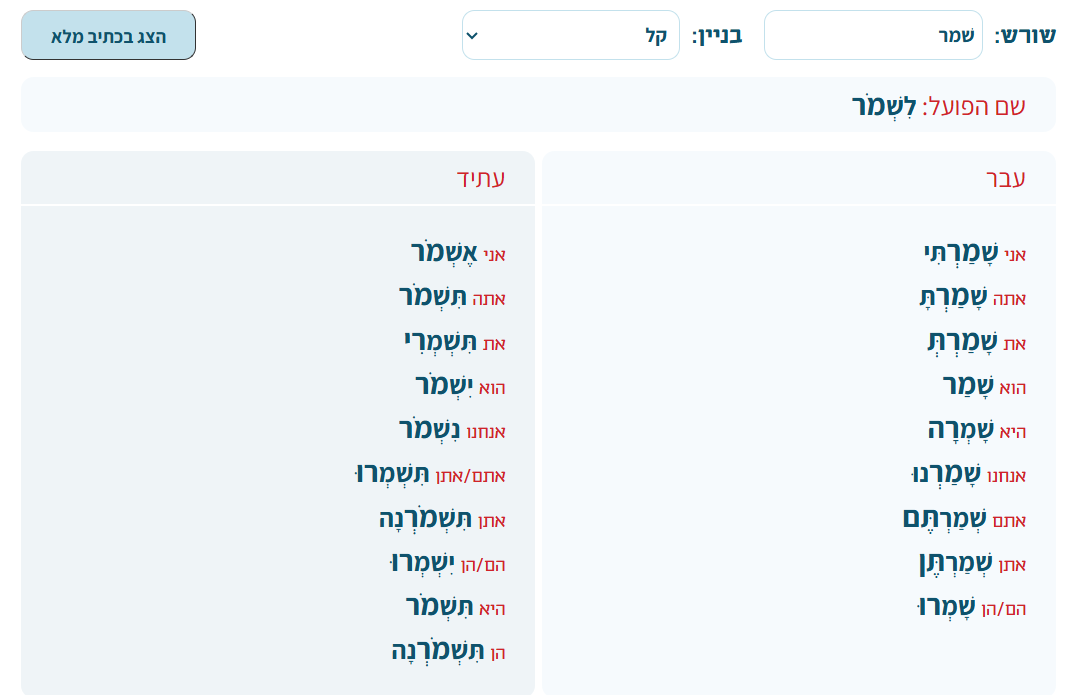

## Data Collection

The is no official API for this dictionary, but we can scrape the data we need.

First, we will inspect the network requests made by the website when we search for a verb.

We notice that after typing at least 2 letters in the search box, the website gives out suggestions for roots.
For example, typing "צה" gives us the following roots: "צהב", "צהל" and "צהר".
This is how it looks in the browser:

![image](resources/prefix_request.png)

Let's take a look at the network requests:
`https://hebrew-academy.org.il/wp-admin/admin-ajax.php?action=get_shoresh_suggestions&_ajax_nonce=b145315ed4&prefix=צה`

The URL contains the path to the ajax request `https://hebrew-academy.org.il/wp-admin/admin-ajax.php`, the specific action we want to perform `action=get_shoresh_suggestions`, a nonce for security `_ajax_nonce=b145315ed4` and the prefix we typed `prefix=צה`.

By sending a GET request to this URL, with all the possible Hebrew prefixes of length 2, we can get all the roots in the dictionary.
Obviously there are no roots of length 1, so it shouldn't be a problem.

What about the conjugation table itself?
When we choose a root and a stem, for example "צהב" and "התפעל" the website gives out the conjugation table.
This is how it looks in the browser:

![image](resources/conjugation_request.png)

Let's take a look at the network requests:
`https://hebrew-academy.org.il/wp-admin/admin-ajax.php?action=get_verb_conjugations&_ajax_nonce=e511734461&shoresh=%D7%A6%D7%94%D7%91&binyan=%D7%94%D7%AA%D7%A4%D7%A2%D7%9C

A similar URL structure, but a different action: `action=get_verb_conjugations`, and different parameters: `shoresh=צהב` and `binyan=התפעל`.
By sending another GET request, this time to the conjugation URL, with all the possible roots and stems, we can get all the conjugation tables in the dictionary.

In [40]:
import pandas as pd
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from itertools import product
from tqdm import tqdm
from typing import Tuple, List
import requests
import json

In [41]:
from pydantic import BaseModel

# Data models for the responses
class RootsResponse(BaseModel):
    Shoresh: str
    Binyanim: list[str]
    Info: str

    def as_entries(self):
        return [(self.Shoresh, binyan) for binyan in self.Binyanim]

class ConjugationsResponse(BaseModel):
    KodHatayot: int
    Shoresh: str
    ShoreshWithShinType: str
    Hehara: str
    Mashmaut: str
    class BinyanModel(BaseModel):
        BinyanKod: int
        BinyanName: str
    Binyan: BinyanModel
    class ZmanimModel(BaseModel):
        KodZman: int
        class InnerZmanimModel(BaseModel):
            Zman: str
            class GufimModel(BaseModel):
                GufHebrew: str
                class HatayaMenukkadModel(BaseModel):
                    Text: str
                    HaeimMutham: bool
                HatayaMenukkad: list[list[HatayaMenukkadModel]]
                class HatayaKtivMaleModel(BaseModel):
                    Text: str
                    HaeimMutham: bool
                HatayaKtivMale: list[list[HatayaKtivMaleModel]]

                def get_hataya_menukkad(self):
                    return [''.join(x.Text for x in i) for i in self.HatayaMenukkad]
            Gufim: list[GufimModel]
        Zmanim: list[InnerZmanimModel]
    Zmanim: list[ZmanimModel]

    def get_entries(self):
        entries = []
        root = self.ShoreshWithShinType.strip()
        stem = self.Binyan.BinyanName.strip()
        for z1 in self.Zmanim:
            for z2 in z1.Zmanim:
                tense = z2.Zman.strip()
                for g in z2.Gufim:
                    for pronoun in g.GufHebrew.split('/'):
                        for conjugation in g.get_hataya_menukkad():
                            entries.append((root, stem, tense, pronoun.strip(), conjugation.strip()))
        return entries

In [42]:
# Website interaction class
class AcademyWebsite:
    def __init__(self, ajax_nonce: str):
        base_url = f'https://hebrew-academy.org.il/wp-admin/admin-ajax.php?_ajax_nonce={ajax_nonce}'
        self.__roots_url = f'{base_url}&action=get_shoresh_suggestions&prefix=%s'
        self.__conjugations_url = f'{base_url}&action=get_verb_conjugations&shoresh=%s&binyan=%s'

        # Standard headers to mimic a real browser
        self.__headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
        }

        self.__expired_nonce_page = '-1'

    def fetch_roots(self, prefix: str) -> List[RootsResponse] | None:
        while True:
            response, success = self.__request(self.__roots_url % prefix)
            if not success:
                continue
            return [RootsResponse(**entry) for entry in response]


    def fetch_conjugations(self, root: str, stem: str) -> List[ConjugationsResponse] | None:
        while True:
            response, success = self.__request(self.__conjugations_url % (root, stem))
            if not success:
                continue
            return [ConjugationsResponse(**entry) for entry in response]

    def __request(self, url: str):
        page_text = requests.get(url, headers=self.__headers).text
        if page_text == self.__expired_nonce_page:
            raise Exception('Expired nonce')

        response = json.loads(page_text)
        if not response['success']:
            print(response)
            return response, False
        return response['data'], True

In [43]:
# Data registry for roots and stems downloaded from the website
class RootsRegistry:
    def __init__(self, file_path: Path, website: AcademyWebsite):
        self.__file_path = file_path
        self.__website = website
        if not self.__file_path.exists():
            self.__download_roots()
        self.dataframe = self.__load_roots()

    def __load_roots(self) -> pd.DataFrame:
        return pd.read_csv(self.__file_path, encoding='utf-16')

    def __download_roots(self) -> None:
        prefixes = self.__generate_size_2_prefixes()
        results = []
        with ThreadPoolExecutor(max_workers=16) as executor:
            futures = {executor.submit(self.__fetch_and_parse, prefix): prefix for prefix in prefixes}
            for future in tqdm(as_completed(futures), total=len(prefixes)):
                results.extend(future.result())
        df = pd.DataFrame(results, columns=['root', 'stem'])
        df.to_csv(self.__file_path, index=False, encoding='utf-16')

    def __fetch_and_parse(self, prefix: str) -> List[Tuple[str, str]]:
        return [entry for response in self.__website.fetch_roots(prefix) for entry in response.as_entries()]

    @staticmethod
    def __generate_size_2_prefixes() -> List[str]:
        alephbet = 'אבגדהוזחטיכלמנסעפצקרשת'
        finals = 'ךםןףץ'
        alephbet_with_finals = alephbet + finals
        return [''.join(pair) for pair in product(alephbet, alephbet_with_finals)]

In [44]:
# Data registry for conjugations downloaded from the website
class ConjugationsRegistry:
    def __init__(self, file_path: Path, website: AcademyWebsite, roots_df: pd.DataFrame):
        self.__file_path = file_path
        self.__website = website
        self.__roots_df = roots_df
        if not self.__file_path.exists():
            self.__download_conjugations()
        self.dataframe = self.__load_conjugations()

    def __load_conjugations(self) -> pd.DataFrame:
        return pd.read_csv(self.__file_path, encoding='utf-16')

    def __download_conjugations(self) -> None:
        results = []
        with ThreadPoolExecutor(max_workers=16) as executor:
            futures = {executor.submit(self.__fetch_and_parse, e): e for e in self.__roots_df.iterrows()}
            for future in tqdm(as_completed(futures), total=len(futures)):
                df = future.result()
                if not df.empty:
                    results.extend(df.values.tolist())
        df = pd.DataFrame(results, columns=['root', 'stem', 'tense', 'pronoun', 'conjugation']).drop_duplicates()
        df.to_csv(self.__file_path, index=False, encoding='utf-16')

    def __fetch_and_parse(self, e):
        _, (root, stem) = e
        responses = self.__website.fetch_conjugations(root, stem)
        rows = [entry for response in responses for entry in response.get_entries()]
        return pd.DataFrame(rows) if rows else pd.DataFrame()

In [45]:
# Dataset downloading and loading

# Change after nonce expiration
AJAX_NONCE = '3a905124a0'
academy_website = AcademyWebsite(AJAX_NONCE)

# Path constants
DATA_DIR = Path('data')
DATA_DIR.mkdir(exist_ok=True)
ROOTS_PATH = Path.joinpath(DATA_DIR, 'roots.csv')
CONJUGATIONS_PATH = Path.joinpath(DATA_DIR, 'conjugations.csv')

roots_registry = RootsRegistry(ROOTS_PATH, academy_website)
print(roots_registry.dataframe.head())

conjugations_registry = ConjugationsRegistry(CONJUGATIONS_PATH, academy_website, roots_registry.dataframe)
print(conjugations_registry.dataframe.head())

100%|██████████| 594/594 [01:13<00:00,  8.06it/s]


  root   stem
0  אנח   נפעל
1  אנח  התפעל
2  אני     קל
3  אני   פיעל
4  אני  פוּעל


100%|██████████| 8219/8219 [21:19<00:00,  6.42it/s]  


  root stem    tense pronoun conjugation
0  אנס   קל  שם פועל     NaN     לֶאֱנֹס
1  אנס   קל      עבר     אני  אָנַסְתִּי
2  אנס   קל      עבר     אתה   אָנַסְתָּ
3  אנס   קל      עבר      את   אָנַסְתְּ
4  אנס   קל      עבר     הוא       אָנַס


## Data Analysis

We have successfully downloaded the data we need. It's located in `data/conjugations.csv`.

A few notes about the processing we performed while downloading the data:
1. We removed duplicated and empty conjugations.
2. We noticed that some conjugations had leading and trailing spaces, which caused the analysis be misleading (same verbs were considered different because of these spaces). We removed these spaces using `strip()` and remained with clean data.
3. We noticed that some verbs had multiple pronouns, separated by a slash (e.g. "הם/הן"). We split these pronouns into separate entries, so each entry has a single pronoun.

Now, let's take a look at the clean data.

Our dataset contains 5 columns:
1. `root` - the verb's root ("שורש"), e.g. "כתב"
2. `stem` - the verb's verbal stem ("בניין"), e.g. "התפעל"
3. `tense` - the verb's tense ("זמן"), e.g. "עבר"
4. `pronoun` - the verb's pronoun ("גוף"), e.g. "הם"
5. `conjugation` - the verb's conjugation with niqqud (or "הטייה"), e.g. "הִתְכַּתְּבוּ"

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

In [47]:
verbs_df = conjugations_registry.dataframe

In [48]:
# Helper function for hebrew phrases display
def fix_hebrew_display(phrase: str) -> str:
    return phrase[::-1].replace(')', '%').replace('(', ')').replace('%', '(')

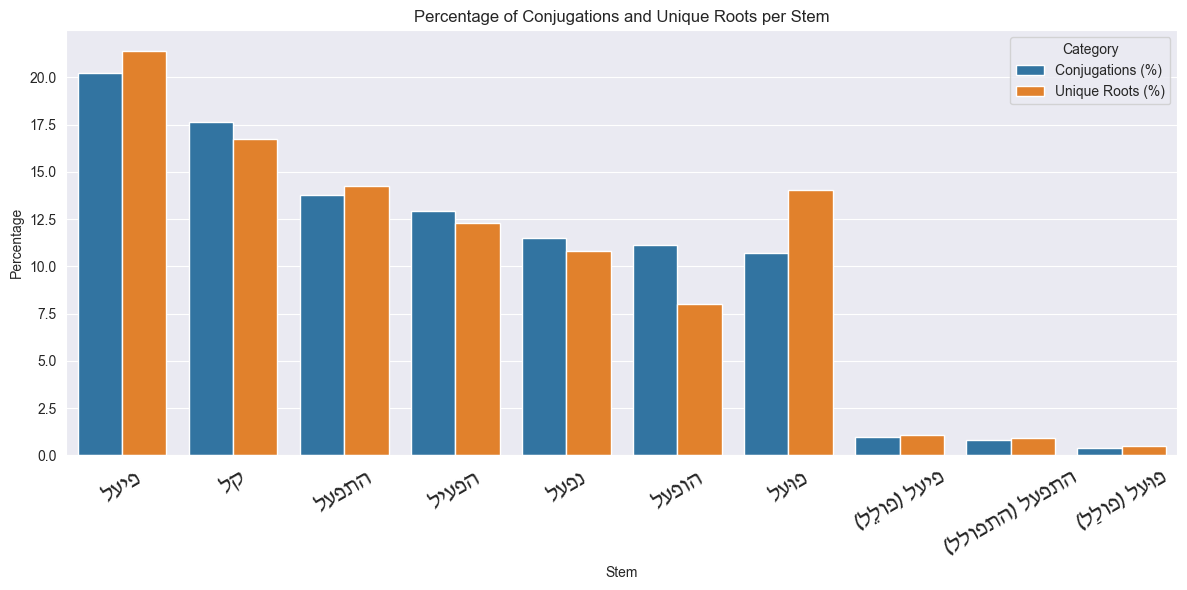

In [49]:
# Calculate distributions per stem
conjugations_percentage = verbs_df['stem'].value_counts(normalize=True).mul(100).rename('Percentage').rename_axis('stem').reset_index().assign(Category='Conjugations (%)')
unique_roots_percentage = verbs_df.groupby('stem')['root'].nunique().pipe(lambda s: s / s.sum() * 100).rename('Percentage').rename_axis('stem').reset_index().assign(Category='Unique Roots (%)')

plot_df = pd.concat([conjugations_percentage, unique_roots_percentage])
plot_df['stem'] = plot_df['stem'].apply(fix_hebrew_display)

plt.figure(figsize=(12, 6))
plt.xticks(rotation=30, fontname='David', fontsize=18)
sns.barplot(data=plot_df, x='stem', y='Percentage', hue='Category')
plt.title('Percentage of Conjugations and Unique Roots per Stem')
plt.xlabel('Stem')

plt.tight_layout()
plt.show()

First, we clearly see that the most common stems are the leftmost 7 stems, as opposed to the rightmost 3 stems which are quite rare.
We can notice that these stems are all special cases.
For example, the stem "התפעל (התפולל)" is a special case of its main stem "התפעל", like in the word "הִתְקוֹמֵם".
We can see that only few unique roots participate in these cases.
Indeed, this only happens in specific verb types (גזרות ע"ע-ע"ו).
It is important to take these cases into account in our analysis - we might consider them as part of their main stem or separate them entirely like seen above.

Second, after deeper inspection, we can see that there are fewer conjugations and unique roots for passive stems ("פועל", "הופעל", "נפעל") compared to their active counterparts ("פיעל", "הפעיל", "קל").

Now let's analyze the distribution of tenses in our dataset.

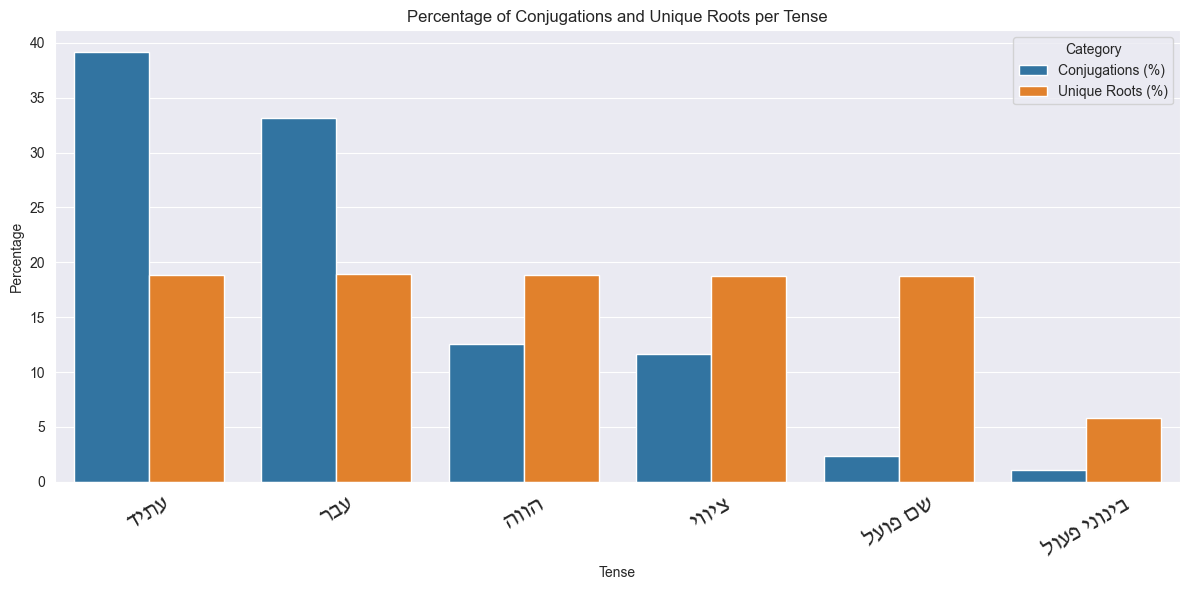

In [50]:
# Calculate distributions per tense
conjugations_percentage = verbs_df['tense'].value_counts(normalize=True).mul(100).rename('Percentage').rename_axis('tense').reset_index().assign(Category='Conjugations (%)')
unique_roots_percentage = verbs_df.groupby('tense')['root'].nunique().pipe(lambda s: s / s.sum() * 100).rename('Percentage').rename_axis('tense').reset_index().assign(Category='Unique Roots (%)')

plot_df = pd.concat([conjugations_percentage, unique_roots_percentage])
plot_df['tense'] = plot_df['tense'].apply(fix_hebrew_display)

plt.figure(figsize=(12, 6))
plt.xticks(rotation=30, fontname='David', fontsize=18)
sns.barplot(data=plot_df, x='tense', y='Percentage', hue='Category')
plt.title('Percentage of Conjugations and Unique Roots per Tense')
plt.xlabel('Tense')

plt.tight_layout()
plt.show()


We see that the most common tenses are "עתיד" and "עבר", which take about 35% of the conjugations each.
After them are "הווה", "ציווי" and "שם פועל".
However, when we look at the unique roots, we see almost no difference between these 5 tenses.
This means that most verbs can be conjugated in all these tenses, but somehow have less conjugations in some tenses.

We have several hypotheses to explain this phenomenon.

First, the tense "ציווי" is used only in the second person, so it has less valid pronouns and therefore fewer conjugations.

Second, the tense "שם פועל" has no pronouns at all, which means it has only one conjugation per verb and stem.

Finally, when viewing the "הווה" tense, there is no intuitive explanation for it. It can be conjugated in all pronouns, so it should have a similar amount of conjugations as "עתיד" and "עבר". A more detailed analysis is needed to understand this phenomenon.

Another interesting observation is the tense "בינוני פעול" which has very few conjugations and unique roots.
This tense is rare and considered "הווה", but it has a different form than the regular "הווה" form.
For example, "אוֹכֵל" in "הווה" becomes "אָכוּל" in "בינוני פעול".

Let's analyze the distribution of pronouns in our dataset and check our hypothesis.

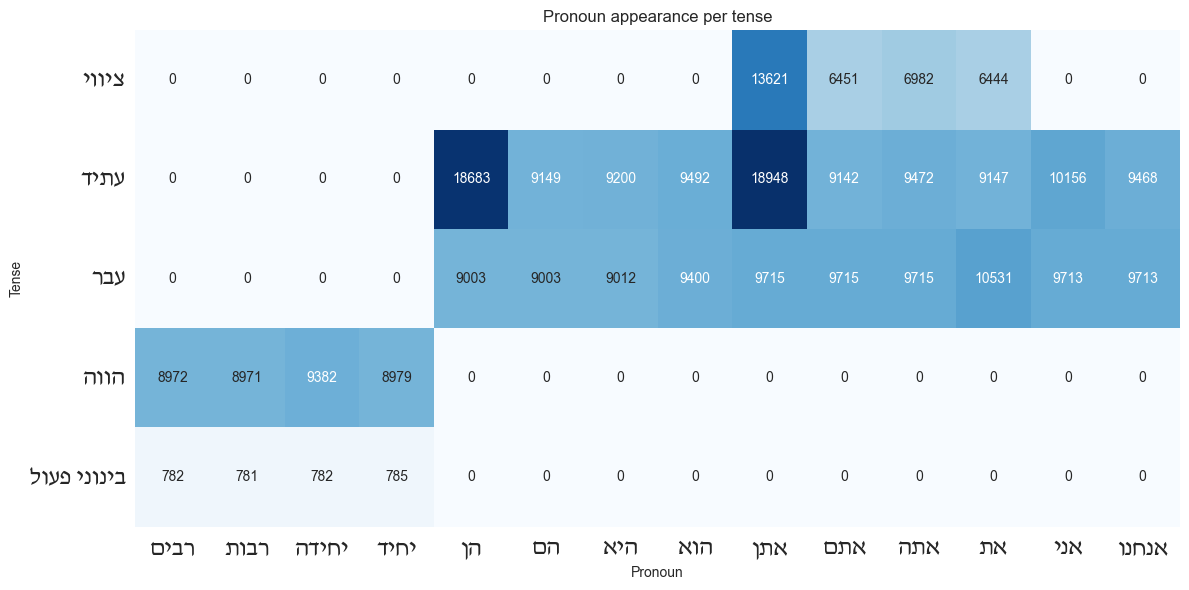

In [51]:
presence = pd.crosstab(verbs_df['tense'], verbs_df['pronoun'])
presence.index = presence.index.map(fix_hebrew_display)
presence.columns = [fix_hebrew_display(p) for p in presence.columns]

plt.figure(figsize=(12, 6))
sns.heatmap(presence, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Pronoun appearance per tense')
plt.xticks(rotation=0, fontname='David', fontsize=18)
plt.yticks(rotation=0, fontname='David', fontsize=18)
plt.xlabel('Pronoun')
plt.ylabel('Tense')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

As clearly seen in the heatmap, our hypotheses are correct.

* The tense "ציווי" appears only in the second-person pronouns ("אתה", "את", "אתם", "אתן"), which explains its low number of conjugations.

* The tense "שם פועל" has no pronouns at all as it does not appear in the heatmap, which explains its very low number of conjugations.

* Also, we can see that the dataset separates the pronouns for the present tenses ("הווה" and "בינוני פעול"). It does not distinguish between different genders (e.g. "יחיד" means "אני", "אתה", "הוא").
This union of pronouns explains the low number of conjugations.
They could be separated into their specific pronouns, which would increase the number of conjugations.

* In addition, we see that "בינוני פעול" is quite rare.

We must also take these observations (especially the last 2) into account.

Another interesting observation is the conjugations of "אתן" or "הן" in "עתיד" tense are double the average of the other pronouns, since they usually have 2 valid conjugations (e.g. "תַּאַסְרוּ" and "תֶּאֱסֹרְנָה").

Something is still missing in our analysis.
We have no idea about the uniqueness of conjugations, i.e., whether a conjugation can belong to multiple verbs or not, and how often this happens.

Take for example the verb "תַּרְצוּ", which can belong to both "אתם" and "אתן" pronouns.

Let's analyze the uniqueness of conjugations in our dataset.

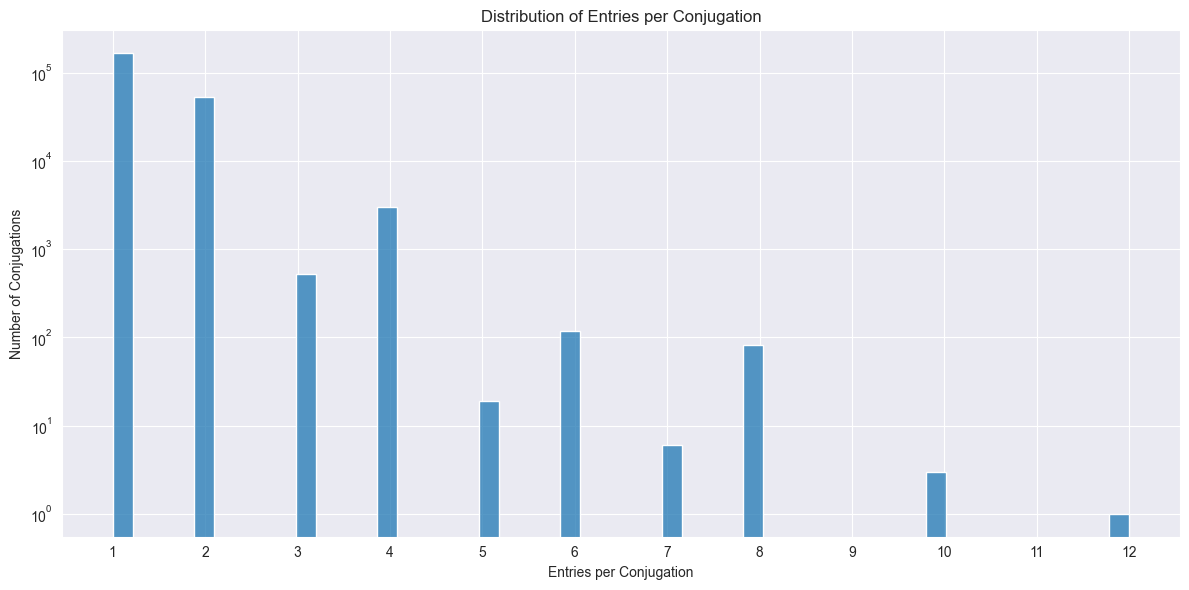

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count how many entries each conjugation has
conj_counts = verbs_df['conjugation'].value_counts()

plt.figure(figsize=(12,6))
sns.histplot(conj_counts, bins=50)

plt.title("Distribution of Entries per Conjugation")
plt.xlabel("Entries per Conjugation")
plt.ylabel("Number of Conjugations")

plt.xticks(range(1, conj_counts.max() + 1))
plt.yscale("log")

plt.tight_layout()
plt.show()

There are verbs with up to 12 different conjugations!

(However, these are very rare, notice that the y-axis is logarithmic)

This will be a challenge for our analyzer, as we will need to return multiple possible analyses for a single conjugation, while only few training samples will be available for these cases.

Let's look why these duplications happen.

In [53]:
# Find the most common conjugation
most_common = verbs_df['conjugation'].value_counts().idxmax()
print('Most common conjugation:', most_common)
print(verbs_df[verbs_df['conjugation'] == most_common])

Most common conjugation: רוֹשְׁשׁוּ
        root           stem  tense pronoun conjugation
236686  רושׁ   פיעל (פולֵל)    עבר      הם  רוֹשְׁשׁוּ
236687  רושׁ   פיעל (פולֵל)    עבר      הן  רוֹשְׁשׁוּ
236704  רושׁ   פיעל (פולֵל)  ציווי     אתם  רוֹשְׁשׁוּ
236705  רושׁ   פיעל (פולֵל)  ציווי     אתן  רוֹשְׁשׁוּ
236753  רושׁ  פוּעל (פולַל)    עבר      הם  רוֹשְׁשׁוּ
236754  רושׁ  פוּעל (פולַל)    עבר      הן  רוֹשְׁשׁוּ
241145  רישׁ  פוּעל (פולַל)    עבר      הם  רוֹשְׁשׁוּ
241147  רישׁ  פוּעל (פולַל)    עבר      הן  רוֹשְׁשׁוּ
241190  רישׁ   פיעל (פולֵל)    עבר      הם  רוֹשְׁשׁוּ
241191  רישׁ   פיעל (פולֵל)    עבר      הן  רוֹשְׁשׁוּ
241208  רישׁ   פיעל (פולֵל)  ציווי     אתם  רוֹשְׁשׁוּ
241209  רישׁ   פיעל (פולֵל)  ציווי     אתן  רוֹשְׁשׁוּ


As we can see, "רוֹשְׁשׁוּ" has 12 different valid conjugations, which is caused by:
1. Different pronouns: "אתם" and "אתן"
2. Different stems: "פיעל (פולֵל)" and "פוּעל (פולַל)"
3. Different roots: "רושׁ" and "רישׁ
4. Different tenses: "עבר" and "ציווי"

This means that every factor can cause a conjugation to be non-unique - there is no single reason for it.